In [3]:
import sys
sys.path.append("pipeline")

In [6]:

import os
import pandas as pd
from pipeline.rapid_transformer import RapidTransformer

parsed_df = pd.read_json("output/normalized/job_parsed_initial.json.gzip", orient='records', lines=True, compression='gzip')
print(parsed_df.shape)

rt = RapidTransformer('initial')
rt.load()

titled = pd.read_csv("../output/final_job_titled.csv")[['job_id', 'title']]
print(titled.shape)

full_df = parsed_df.explode('job_ids').rename(columns={'job_ids': 'job_id'})
full_df = full_df.merge(rt.job_df, on=['job_id'], how='inner', suffixes=('', '_rapid'))
full_df = full_df.merge(rt.desc_df, on=['job_description_id'], how='inner', suffixes=('_openai', ''))
full_df = full_df.merge(titled, on=['job_id'], how='inner')
full_df.drop(['file_name'], axis=1, inplace=True)
full_df.drop_duplicates(subset=['job_id', 'job_description_id'], inplace=True)
full_df.drop(['job_description_rapid', 'job_title_rapid'], axis=1, inplace=True)
print(full_df.shape)

(13357, 23)
(12353, 2)
(12417, 66)


In [79]:
df = full_df[full_df['title'].isna()]
df = df[df['it_tech_keywords'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)]
df = df.fillna('')
df.shape

In [95]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import numpy as np
from itertools import product
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



weight_ranges = {
     "job_title": [1.5],
     "job_title_openai": [1.5],
     "core_technical_skills": [1.0],
     "subject_area_specific_skills": [1.0],
     "it_tech_keywords": [1.0],
     "tech_keywords": [2.0],
     "ml_keywords": [2.0],
     "devops_keywords": [2.0],
     "cloud_keywords": [2.0],
     "ai_group_keywords": [2.0],
     "qual_keywords": [3.0],
     "cert_keywords": [3.0],
     "job_category": [1.0],
     "category": [1.0],
     "search": [1.0],
}


# Generate all combinations of weights
keys, values = zip(*weight_ranges.items())
weight_combinations = [dict(zip(keys, v)) for v in product(*values)]
weights = weight_combinations[0]

best_score = -1
best_weights = None
best_X = None
best_labels = None
metrics_clusters = {}

i=0

# Iterate through weight combinations
for clusters in range(20, 30):
    ct = ColumnTransformer(
        transformers=[
            ("job_title", TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words=None, min_df=1), "job_title"),
            ("job_title_openai", TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words=None, min_df=1), "job_title"),
            ("category", TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words=None, min_df=1), "category"),
            ("search", TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words=None, min_df=1), "search"),
            
            # ("core_technical_skills", TfidfVectorizer(analyzer=lambda x: x, lowercase=True, stop_words=None, min_df=1), "core_technical_skills"), 
            # ("subject_area_specific_skills", TfidfVectorizer(analyzer=lambda x: x, lowercase=True, stop_words=None, min_df=1), "subject_area_specific_skills"), 
            ("it_tech_keywords", TfidfVectorizer(analyzer=lambda x: x, lowercase=True, stop_words=None, min_df=1), "it_tech_keywords"), 
            # 
            # ("tech_keywords", TfidfVectorizer(analyzer=lambda x: x, lowercase=True, stop_words=None, min_df=1), "tech_keywords"),
            # ("ml_keywords", TfidfVectorizer(analyzer=lambda x: x, lowercase=True, stop_words=None, min_df=1), "ml_keywords"),
            # ("devops_keywords", TfidfVectorizer(analyzer=lambda x: x, lowercase=True, stop_words=None, min_df=1), "devops_keywords"),
            # ("cloud_keywords", TfidfVectorizer(analyzer=lambda x: x, lowercase=True, stop_words=None, min_df=1), "cloud_keywords"),
            # ("ai_group_keywords", TfidfVectorizer(analyzer=lambda x: x, lowercase=True, stop_words=None, min_df=1), "ai_group_keywords"),
            # ("qual_keywords", TfidfVectorizer(analyzer=lambda x: x, lowercase=True, stop_words=None, min_df=1), "qual_keywords"),
            # ("cert_keywords", TfidfVectorizer(analyzer=lambda x: x, lowercase=True, stop_words=None, min_df=1), "cert_keywords"),
    
        ],
        transformer_weights=weights,
    )
    
    pipe = make_pipeline(ct, TruncatedSVD(256, random_state=42), KMeans(n_clusters=clusters, n_init="auto", random_state=42))
    
    X_encoded = pipe.named_steps['truncatedsvd'].fit_transform(ct.fit_transform(df))
    kmeans = pipe.named_steps['kmeans']
    labels = kmeans.fit_predict(X_encoded)
    df['kmeans_' + str(clusters)] = labels 
    
    silhouette = silhouette_score(X_encoded, labels)
    if silhouette > best_score:
        best_score = silhouette
        best_weights = weights
        best_X = X_encoded
        best_labels = labels
    
    metrics_clusters[str(clusters)] = silhouette
    print(f"Silhouette Score {clusters}: {silhouette}")


Silhouette Score 20: 0.1072918496589455
Silhouette Score 21: 0.08791533475398254
Silhouette Score 22: 0.09330065270178221
Silhouette Score 23: 0.09315781653698228
Silhouette Score 24: 0.09448859090840823
Silhouette Score 25: 0.10136550095624258
Silhouette Score 26: 0.10302937272585151
Silhouette Score 27: 0.10721810147533424
Silhouette Score 28: 0.10439403838703794
Silhouette Score 29: 0.10892477888477042


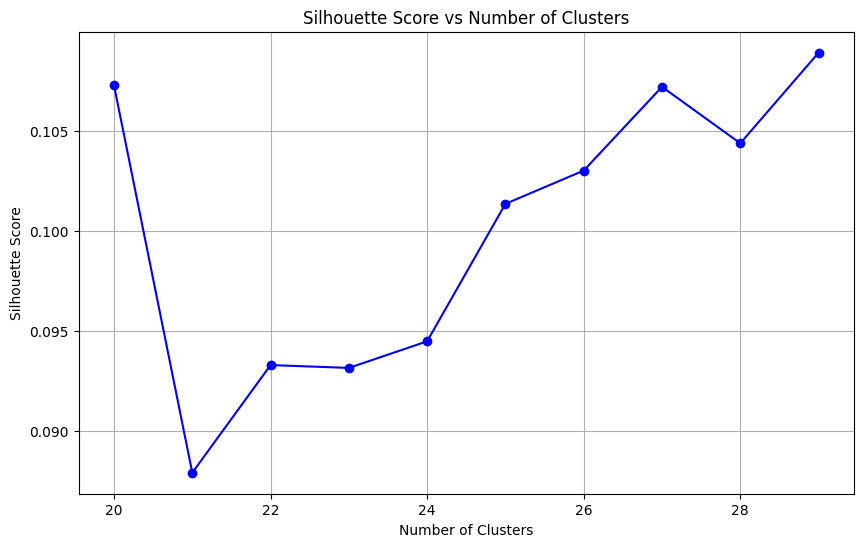

In [96]:
import matplotlib.pyplot as plt

# Extract cluster counts and silhouette scores
cluster_counts = list(map(int, metrics_clusters.keys()))
silhouette_scores = list(metrics_clusters.values())

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

(2376, 2)


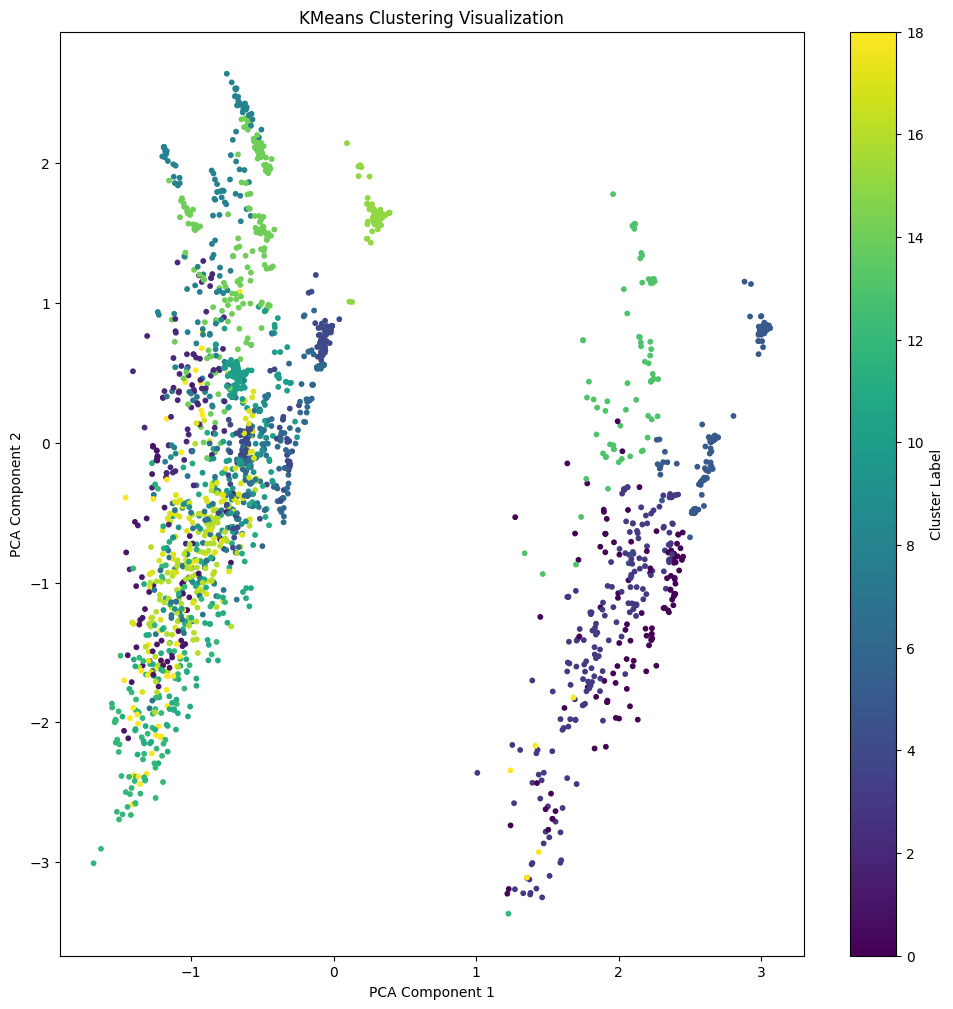

In [86]:
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_emb_2d = pca.fit_transform(best_X)
print(X_emb_2d.shape)
# Plot the clusters
plt.figure(figsize=(12, 12))
plt.scatter(X_emb_2d[:, 0], X_emb_2d[:, 1], c=best_labels, cmap='viridis', s=10)
plt.colorbar(label='Cluster Label')
plt.title('KMeans Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

